<a href="https://colab.research.google.com/github/tamasdoka/str_opt/blob/dev/steering_optimizer_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steering geometry optimizer with stable baselines

Github Repo: [https://github.com/tamasdoka/str_opt](https://github.com/tamasdoka/str_opt)

In [0]:
#!apt install swig cmake libopenmpi-dev zlib1g-dev
#!pip install stable-baselines[mpi]==2.8.0 box2d box2d-kengz
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x

# Import gym, numpy and stable baselines

In [0]:
%%capture
import gym
import numpy as np

from stable_baselines import DQN

## Cloning and intalling the Gym env and instantiate the agent


In [19]:
!git clone -b dev https://github.com/tamasdoka/str_opt/

Cloning into 'str_opt'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 538 (delta 77), reused 119 (delta 39), pack-reused 357
Receiving objects: 100% (538/538), 7.01 MiB | 4.83 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [20]:
!pip install -e /content/str_opt/steering-optimizer

Obtaining file:///content/str_opt/steering-optimizer
  Found existing installation: steering-optimizer 0.0.1
    Can't uninstall 'steering-optimizer'. No files were found to uninstall.
  Running setup.py develop for steering-optimizer


In [0]:
for env in gym.envs.registry.env_specs.keys():
     if 'steering_optimizer' in env:
          print('Remove {} from registry".format(env)')
          del gym.envs.registry.env_specs[env]

In [0]:
from gym.envs.registration import register

register(
    id='steering_optimizer-v0',
    entry_point='steering_optimizer.envs:StrOptEnv')

In [24]:
%cd /content/str_opt/steering-optimizer/


/content/str_opt/steering-optimizer


In [0]:
env = gym.make('steering_optimizer-v0')

In [26]:
env.check_version()

StrOpt version: dev


## Creating the model

In [0]:
model = DQN('MlpPolicy', env, learning_rate=1e-2, exploration_fraction=0.5, prioritized_replay=True, verbose=1)

Function for model evaluation

In [0]:
def evaluate(model, num_steps=100):
  """
  Evaluate a RL agent
  :param model: (BaseRLModel object) the RL Agent
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episode_rewards = [0.0]
  rewards = []
  states = []
  obs = env.reset()
  print('state:', obs)
  for i in range(num_steps):
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)

      print('action:', action)

      obs, reward, done, info = env.step(action)

      print('obs (state), reward, done:', obs, reward, done)
      
      # Stats
      episode_rewards[-1] += reward
      rewards.append(reward)
      states.append(obs)
      if done:
          obs = env.reset()
          episode_rewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  best_reward_index = np.argmax(episode_rewards)
  best_state = states[best_reward_index]
  best_reward = rewards[best_reward_index]

  print('Best reward:', best_reward)
  print('Best state:', best_state)
  
  return mean_100ep_reward

Model before training

In [29]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_steps=1000)

state: [ -63.40334617   56.02916332 -405.04780952   21.87547146]
action: 2
obs (state), reward, done: [ -58.40334617   56.02916332 -405.04780952   21.87547146] 0.0 False
action: 2
obs (state), reward, done: [ -53.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -48.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -43.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -38.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -33.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -28.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -23.40334617   56.02916332 -405.04780952   21.87547146] 0.01 False
action: 2
obs (state), reward, done: [ -18.40334617   56.02916332 -405.04780952   21.875

     fun: 0.3201729811745673
     jac: array([-0.00143996, -0.00236953,  0.01342568,  0.00144795])
 message: 'Optimization terminated successfully.'
    nfev: 227
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([ -98.78558556, -196.21455101, -435.8356844 , -103.65416148])


[10, 30.57131496310631, 0, 2]

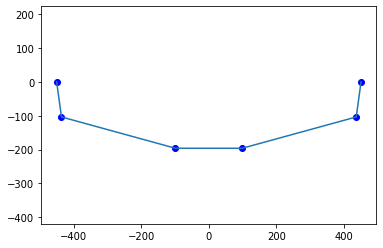

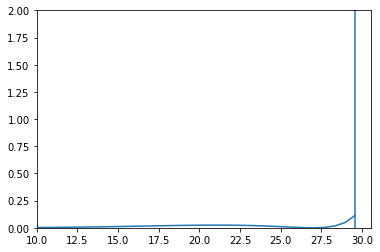

In [30]:
# Searching optimal solution with scipy.optimize

import matplotlib.pyplot as plt

solution = env.geometry_optimize()
print(solution)

val = solution.x
plt.plot([env.KPLX, val[2], val[0], -val[0], -val[2], -env.KPLX], [env.KPLY, val[3], val[1], val[1], val[3], env.KPLY], 'bo')
plt.plot([env.KPLX, val[2], val[0], -val[0], -val[2], -env.KPLX], [env.KPLY, val[3], val[1], val[1], val[3], env.KPLY])
plt.axis('equal')

env.state = solution.x

env.step(0)

plt.figure()
plt.plot(env.check_r*180/np.pi, env.check_error*180/np.pi)
plt.axvline(x=env.border_ang / np.pi * 180)
plt.axis([10, (env.border_ang / np.pi * 180) + 1, 0, 2])


## Train the agent and save it

Warning: this may take a while

In [0]:
# Train the agent
model.learn(total_timesteps=int(2e5), log_interval=10)
# Save the agent
model.save("dqn_steering_opt")
del model  # delete trained model to demonstrate loading

#2
init, arm, tie 62.62555507062744 39.64278681061264 102.24414000490812
Done: Reached error threshold!
#2
init, arm, tie 22.127121978246905 95.41677512721782 73.71061026509815


/content/str_opt/steering-optimizer/steering_optimizer/envs/optimizer_env.py:32: RuntimeWarning: invalid value encountered in double_scalars
  chop = (angle*180/np.pi) % (np.sign(angle)*180)*np.pi/180


Bad front facing because of betas!
Mark True
steps since reset 1
nan
signs of operands -1.0 nan
Possible ARMS_ca -3.706847425714648e-09 0.000542721403724256
ARM_ca 0.000542721403724256
angdiff_c, 0: -0.00027135884843687563 179.99972863744472
angdiff_c, 1: -0.00027135884843687563 -179.9997286374447
initalpha, alpha_c, betadeg, beta_c 13.877028192488165 166.12297180751182 13.87729955133659 166.1227004486634
diff_calc -166.12297180751185
#1 - separate dist, arm, tie 147.0968163100186 117.93640915650094 27.713079305031208
#1 - separate dist, arm, tie 62.40119317314865 35.08828787770424 26.14887800258907
#1 - separate dist, arm, tie 123.74103194546282 34.56495914132961 88.93797527255632
#1 - separate dist, arm, tie 129.32014042226808 77.66649052671347 49.364131048627996
#1 - separate dist, arm, tie 34.29537734627755 27.91121564988415 6.381162245825086
#1 - separate dist, arm, tie 80.73717728505183 45.101349951996205 35.54860787605915
#1 - separate dist, arm, tie 118.81873603408339 105.81132

## Load the trained agent

In [0]:
model = DQN.load("dqn_steering_opt")

In [0]:
# Evaluate the trained agent
mean_reward = evaluate(model, num_steps=5000)